In [3]:
import os
import sys
sys.path.append(os.getcwd())

In [4]:
import wandb
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation


In [5]:
def fetch_hessian_eigenvalues(project, run):
    """Fetch the Hessian eigenvalues from a wandb run."""
    eigenvalues_artifact = wandb.Api().artifact(f"wlp9800-new-york-university/{project}/run-{run.id}-hessian_eigenvalues:v0")
    artifact_dir = eigenvalues_artifact.download()
    
    with open(f"{artifact_dir}/hessian_eigenvalues.table.json") as file:
        json_dict = json.load(file)
    
    df = pd.DataFrame(json_dict["data"], columns=json_dict["columns"])
    return df.to_numpy()[1:]  # Remove first row

def fetch_hyperparameters(run):
    history = run.history(keys=["hyperparameters"], pandas=True, samples=10_000)
    if "hyperparameters" in history and not history.empty:
        history = history.iloc[1:]  # Remove the first row
    return history["hyperparameters"].values if "hyperparameters" in history else None


In [6]:
api = wandb.Api()
sweep_list = [
    ("rnn-test", "ll2rh1tb"),
    ("rnn-test", "24wnnntk"),
    ("rnn-test", "z7twlfda"),
    ("rnn-test", "j9gac6ff"),
]

data = {}
# Download all data first
for project, sweep_id in sweep_list:
    sweep = api.sweep(f"wlp9800-new-york-university/{project}/{sweep_id}")
    data[sweep_id] = {}
    
    for run in sweep.runs:
        # Pre-download the eigenvalues and hyperparameters
        eigenvalues = fetch_hessian_eigenvalues(project, run)
        hyperparams = fetch_hyperparameters(run)
        
        # Store the downloaded data
        data[sweep_id][run.id] = {
            "eigenvalues": eigenvalues,
            "hyperparameters": hyperparams,
            "url": run.url,
        }


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  


In [15]:
def detect_explosion(eigenvalues_per_epoch, threshold=1e3):
    log_abs_eigenvalues = np.log(np.abs(eigenvalues_per_epoch))
    log_cumprod_vals = np.cumsum(log_abs_eigenvalues, axis=0)
    log_threshold = np.log(threshold)
    exceeded_epochs = np.where(np.any(log_cumprod_vals > log_threshold, axis=1))[0]
    
    if len(exceeded_epochs) > 0:
        t = exceeded_epochs[0]
        exceeded_columns = np.where(log_cumprod_vals[t] > log_threshold)[0]
        return eigenvalues_per_epoch[: t + 1, exceeded_columns], log_cumprod_vals[:, exceeded_columns]
    
    return np.array([]), np.array([])

def detect_underflow(eigenvalues_per_epoch):
    """
    Detects when the eigenvalues underflow by becoming extremely small (near zero), using system minimum positive number.

    Args:
        eigenvalues_per_epoch (numpy.ndarray): The eigenvalues at each epoch.
    
    Returns:
        tuple: A tuple containing two arrays:
            - Eigenvalues that underflowed
            - Cumulative log values for these eigenvalues
    """
    # Get the smallest positive normalized value representable by the system
    min_positive = np.finfo(float).tiny
    
    # Calculate the log of absolute eigenvalues
    log_abs_eigenvalues = np.log(np.abs(eigenvalues_per_epoch))
    
    # Calculate the cumulative sum of the log values
    log_cumprod_vals = np.cumsum(log_abs_eigenvalues, axis=0)
    
    # Find where log values are smaller than log of the system's minimum positive number
    log_threshold = np.log(min_positive)
    
    underflowed_epochs = np.where(np.any(log_cumprod_vals < log_threshold, axis=1))[0]
    
    if len(underflowed_epochs) > 0:
        t = underflowed_epochs[0]  # The first epoch where underflow occurs
        underflowed_columns = np.where(log_cumprod_vals[t] < log_threshold)[0]  # Which dimensions underflowed
        return eigenvalues_per_epoch[:t + 1, underflowed_columns], log_cumprod_vals[:, underflowed_columns]
    
    return np.array([]), np.array([])


def plot_trajectory_with_greatest_log_cumsum(eigenvalues_per_epoch, title):
    # Calculate log-cumsum along axis 0 (epoch-wise cumulative sum for each dimension)
    log_abs_eigenvalues = np.log(np.abs(eigenvalues_per_epoch))  # Ensure log transformation
    log_cumsum_vals = np.cumsum(log_abs_eigenvalues, axis=0)  # Cumulative sum in log space
    
    # Find the dimension (column) with the highest final log cumulative sum
    final_log_cumsum = log_cumsum_vals[-1, :]  # Get the last row (final sum for each dimension)
    max_log_cumsum_index = np.argmax(final_log_cumsum)  # Find the index of the max log cumsum
    
    # Plot the trajectory of the dimension with the greatest log cumsum
    plt.figure(figsize=(10, 6))
    plt.plot(log_cumsum_vals[:, max_log_cumsum_index], label=f"Dimension {max_log_cumsum_index+1}")
    plt.xlabel("Epoch")
    plt.ylabel("Log of Eigenvalues")
    plt.title(f"{title} (Dimension with Greatest Log Cumsum)")
    plt.legend()
    plt.show()


    plt.figure(figsize=(10, 6))
    plt.plot(eigenvalues_per_epoch[:, max_log_cumsum_index], label=f"Dimension {max_log_cumsum_index+1}")
    plt.xlabel("Epoch")
    plt.ylabel("Log of Eigenvalues")
    plt.title(f"{title} (Dimension with Greatest Log Cumsum)")
    plt.legend()
    plt.show()

def plot_eigenvalues(vals, title):
    plt.figure(figsize=(10, 6))
    for i in range(vals.shape[1]):
        plt.plot(vals[:, i], label=f"Dimension {i+1}")
    plt.xlabel("Epoch")
    plt.ylabel("Cumulative Eigenvalues")
    plt.title(title)
    plt.legend()
    plt.show()

def plot_first_dimension(eigenvalues_per_epoch, title):
    plt.figure(figsize=(10, 6))
    plt.plot(eigenvalues_per_epoch[:, 0], label="Dimension 1")
    plt.xlabel("Epoch")
    plt.ylabel("Eigenvalues")
    plt.title(title)
    plt.legend()
    plt.show()


def compute_frobenius_norm(eigenvalues_per_epoch):
    return np.sqrt(np.sum(np.square(eigenvalues_per_epoch), axis=1))

def plot_frobenius_norm(frobenius_norms, title="Frobenius Norm Over Time"):
    plt.figure(figsize=(8, 5))
    plt.plot(frobenius_norms, label="Frobenius Norm")
    plt.xlabel("Epoch")
    plt.ylabel("Frobenius Norm")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()



def detect_explosion_and_print_array(frobenius_norms, eigenvalues_per_epoch, threshold_factor=10):
    max_norm = np.max(frobenius_norms)
    threshold = threshold_factor * np.mean(frobenius_norms)  # Dynamically setting a threshold
    
    for epoch, norm in enumerate(frobenius_norms):
        if norm > 35.:  # Adjust the threshold as needed for the explosion detection
            print(f"Explosion detected at epoch {epoch}!")
            print(f"Frobenius norm: {norm}")
            print(f"Eigenvalues at epoch {epoch}: {eigenvalues_per_epoch[epoch]}")
            print(f"Eigenvalues at epoch {epoch-1}: {eigenvalues_per_epoch[epoch-1]}")
            print(f"Frobenius norm at epoch {epoch-1}: {frobenius_norms[epoch-1]}")

            # Eigenvalue difference between epoch of explosion and previous epoch
            eigenvalues_curr = np.array(eigenvalues_per_epoch[epoch-1])
            eigenvalues_prev = np.array(eigenvalues_per_epoch[epoch-2])
            eigenvalue_diff = eigenvalues_curr - eigenvalues_prev

            print(f"Eigenvalue differences (Epoch {epoch} - Epoch {epoch-1}):")
            print(eigenvalue_diff)
            
            # Plot histograms for the last 20 epochs before explosion (or as many as available)
            start_epoch = max(0, epoch - 20)
            for e in range(start_epoch, epoch + 1):
                plt.figure(figsize=(8, 6))
                plt.hist(eigenvalues_per_epoch[e], bins=50, color='skyblue', edgecolor='black')
                plt.title(f"Histogram of Eigenvalues at Epoch {e}")
                plt.xlabel("Eigenvalue")
                plt.ylabel("Frequency")
                plt.grid(True)
                plt.show()
            
            break




def transform_eigenvalues(eigenvalues, hyperparams):
    """Apply the transformation lambda_new_t = (1 - lambda_old_t) / hyperparameter_t."""
    return (1 - eigenvalues) / hyperparams[:, np.newaxis]

def plot_transformed_eigenvalues(hyperparams, transformed_eigenvalues, run_name):
    """Plot 2/hyperparameter_t and transformed eigenvalues over time."""
    epochs = np.arange(len(hyperparams))
    plt.figure(figsize=(10, 6))
    
    # Plot 2/hyperparameter_t
    plt.plot(epochs, 2 / hyperparams, label=r"$\frac{2}{\text{hyperparameter}_t}$", color='black', linestyle='dashed')
    
    # Plot each transformed eigenvalue over time
    for i in range(transformed_eigenvalues.shape[1]):
        plt.plot(epochs, transformed_eigenvalues[:, i], alpha=0.6)
    
    plt.xlabel("Epoch")
    plt.ylabel("Value")
    plt.title(f"Transformed Eigenvalues and 2/Hyperparameter over Time ({run_name})")
    plt.legend()
    plt.grid()
    plt.show()


def plot_transformed_eigenvalues_2(hyperparams, transformed_eigenvalues, run_name):
    """Plot 2/hyperparameter_t and transformed eigenvalues over time, showing only values above 1 on the y-axis."""
    epochs = np.arange(len(hyperparams))
    plt.figure(figsize=(10, 6))
    
    # Plot each transformed eigenvalue over time
    for i in range(transformed_eigenvalues.shape[1]):
        plt.plot(epochs, transformed_eigenvalues[:, i], alpha=0.6)

    plt.xlabel("Epoch")
    plt.ylabel("Value")
    plt.title(f"Transformed Eigenvalues and 2/Hyperparameter over Time ({run_name})")
    plt.ylim(1, None)  # Set the y-axis lower limit to 1
    plt.grid()
    plt.show()

Run link: https://wandb.ai/wlp9800-new-york-university/rnn-test/runs/vl152psj


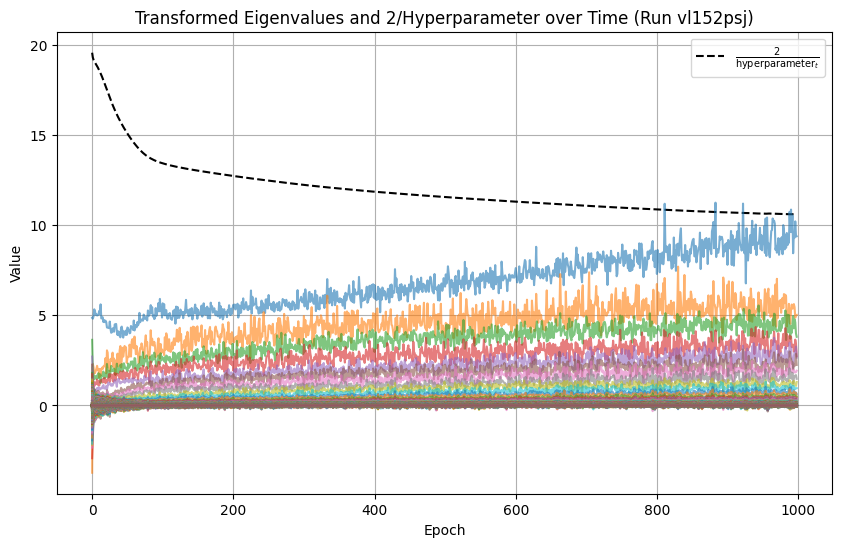

Run link: https://wandb.ai/wlp9800-new-york-university/rnn-test/runs/9hvetqgn


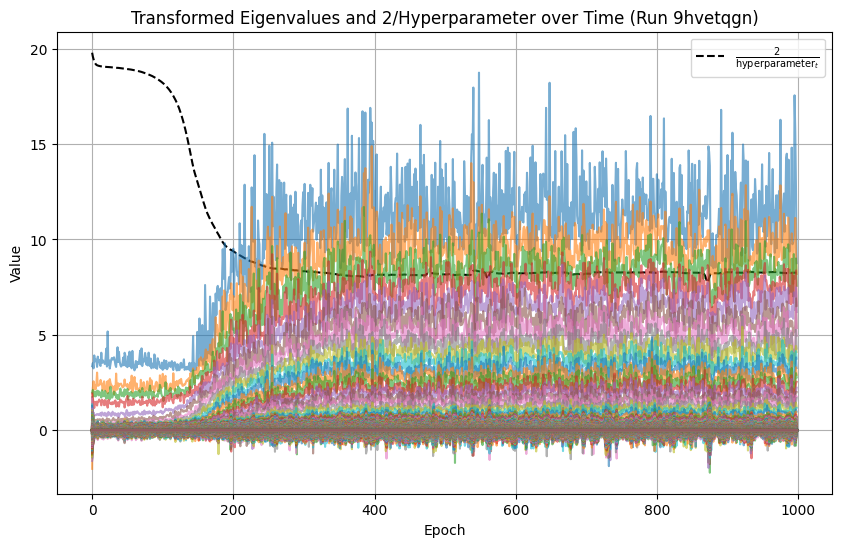

Run link: https://wandb.ai/wlp9800-new-york-university/rnn-test/runs/gtaztzr2


/tmp/ipykernel_2755/2658903618.py:148: RuntimeWarning: divide by zero encountered in divide
  return (1 - eigenvalues) / hyperparams[:, np.newaxis]
/tmp/ipykernel_2755/2658903618.py:148: RuntimeWarning: invalid value encountered in divide
  return (1 - eigenvalues) / hyperparams[:, np.newaxis]
/tmp/ipykernel_2755/2658903618.py:156: RuntimeWarning: divide by zero encountered in divide
  plt.plot(epochs, 2 / hyperparams, label=r"$\frac{2}{\text{hyperparameter}_t}$", color='black', linestyle='dashed')


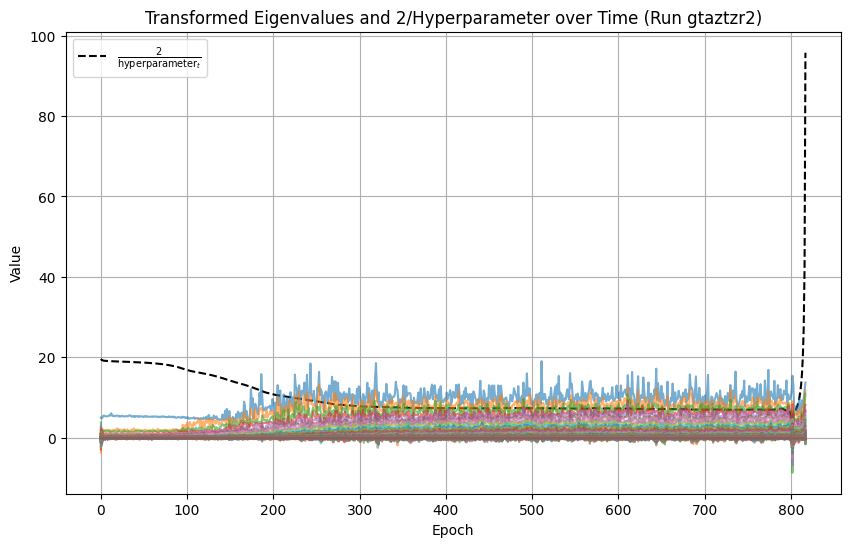

Run link: https://wandb.ai/wlp9800-new-york-university/rnn-test/runs/srizfldp


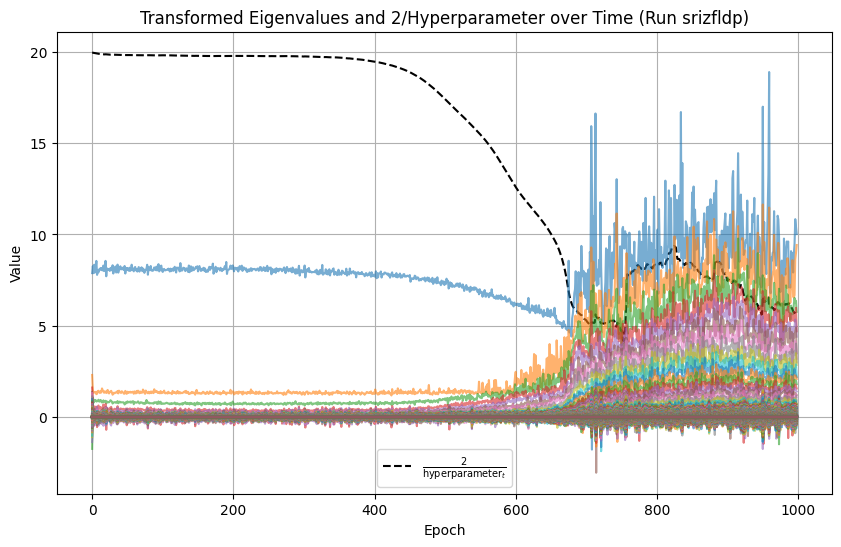

In [8]:
for sweep_id, runs in data.items():
    for run_id, run_info in runs.items():
        eigenvalues = run_info["eigenvalues"]
        hyperparams = run_info["hyperparameters"]

        print(f"Run link: {run_info['url']}")
        
        # Check if hyperparameters and eigenvalues match in length
        if hyperparams is not None and len(hyperparams) == eigenvalues.shape[0]:
            transformed_eigenvalues = transform_eigenvalues(eigenvalues, hyperparams)
            plot_transformed_eigenvalues(hyperparams, transformed_eigenvalues, f"Run {run_id}")
        else:
            print(f"Skipping run {run_id} due to missing or mismatched hyperparameter data.")

Run link: https://wandb.ai/wlp9800-new-york-university/rnn-test/runs/vl152psj


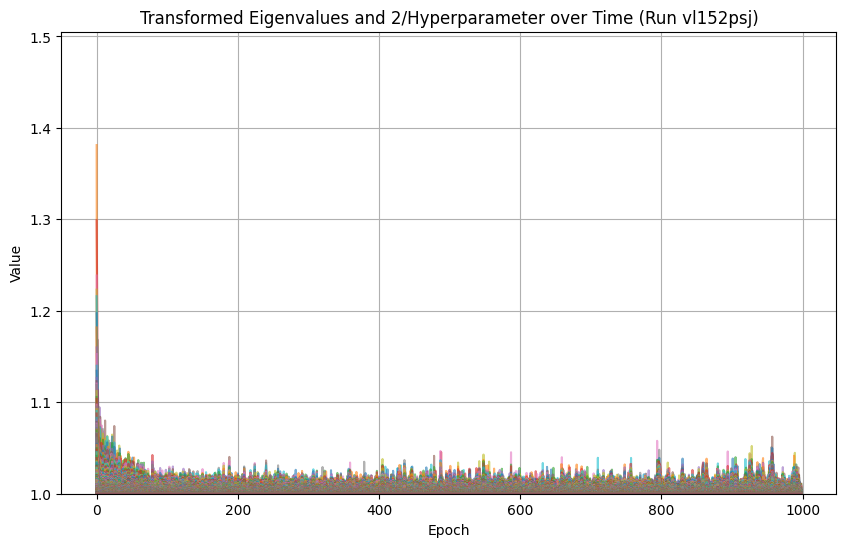

Run link: https://wandb.ai/wlp9800-new-york-university/rnn-test/runs/9hvetqgn


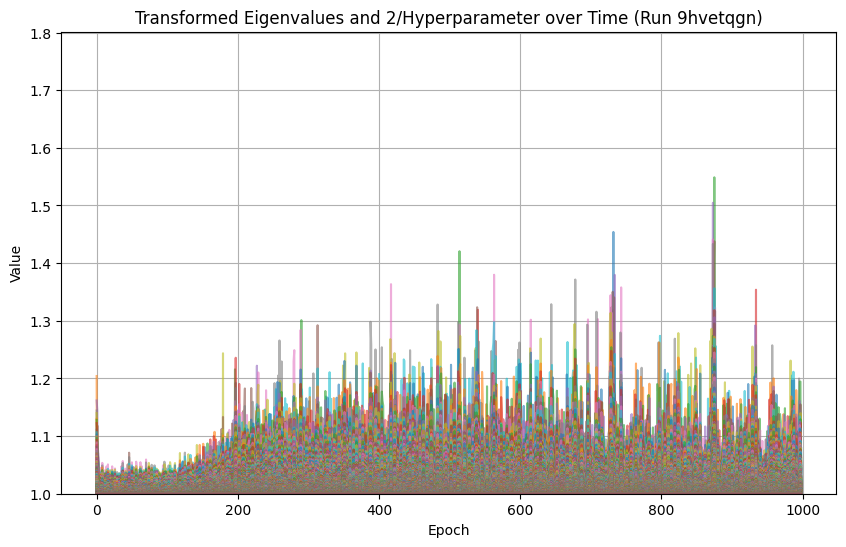

Run link: https://wandb.ai/wlp9800-new-york-university/rnn-test/runs/gtaztzr2


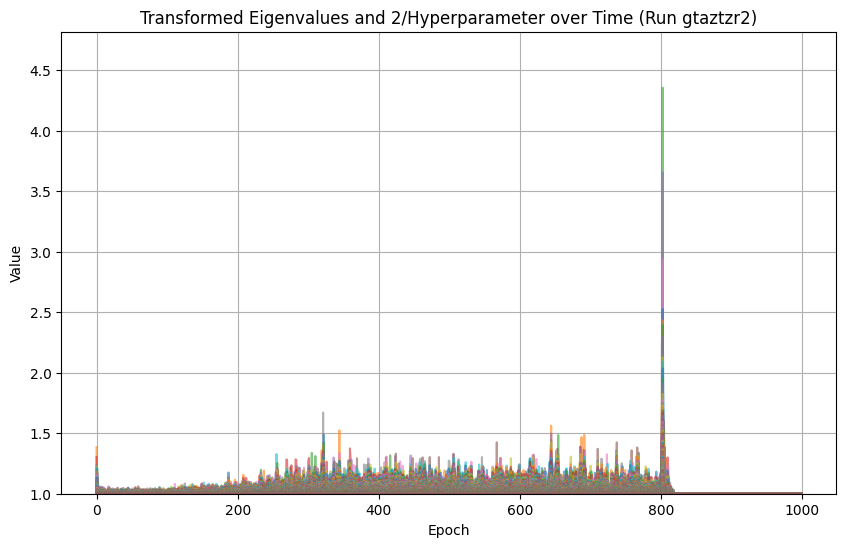

Run link: https://wandb.ai/wlp9800-new-york-university/rnn-test/runs/srizfldp


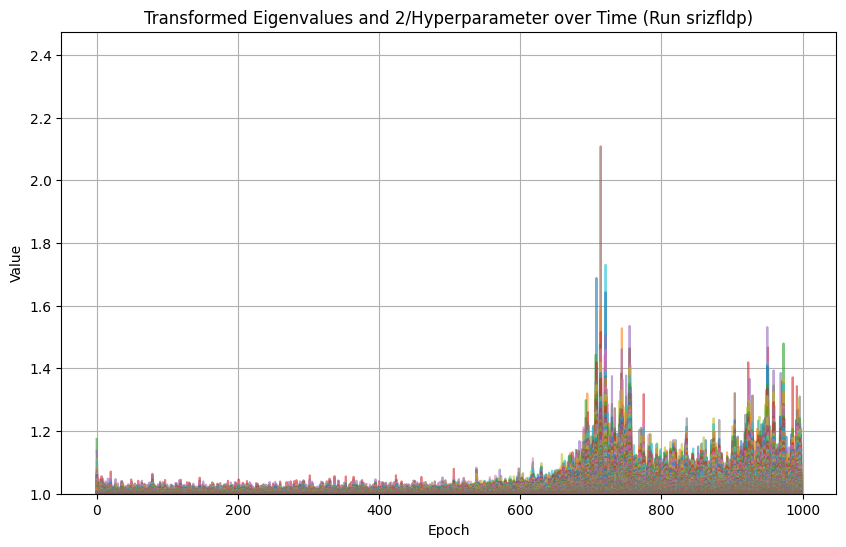

In [16]:
for sweep_id, runs in data.items():
    for run_id, run_info in runs.items():
        eigenvalues = run_info["eigenvalues"]
        hyperparams = run_info["hyperparameters"]

        print(f"Run link: {run_info['url']}")
        
        # Check if hyperparameters and eigenvalues match in length
        if hyperparams is not None and len(hyperparams) == eigenvalues.shape[0]:
            plot_transformed_eigenvalues_2(hyperparams, eigenvalues, f"Run {run_id}")
        else:
            print(f"Skipping run {run_id} due to missing or mismatched hyperparameter data.")

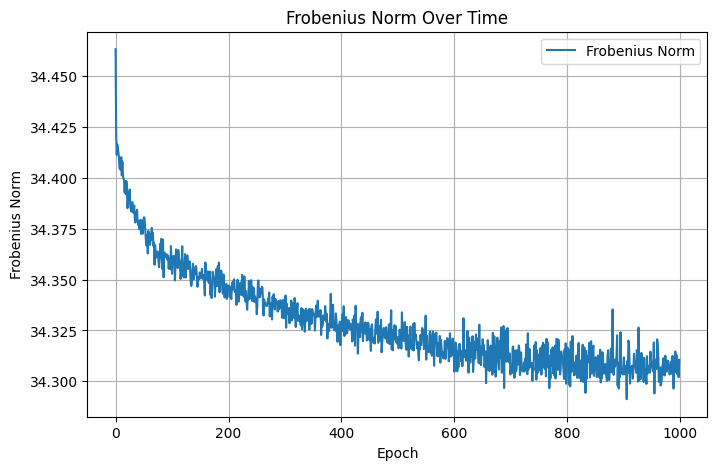

Run link: https://wandb.ai/wlp9800-new-york-university/rnn-test/runs/vl152psj


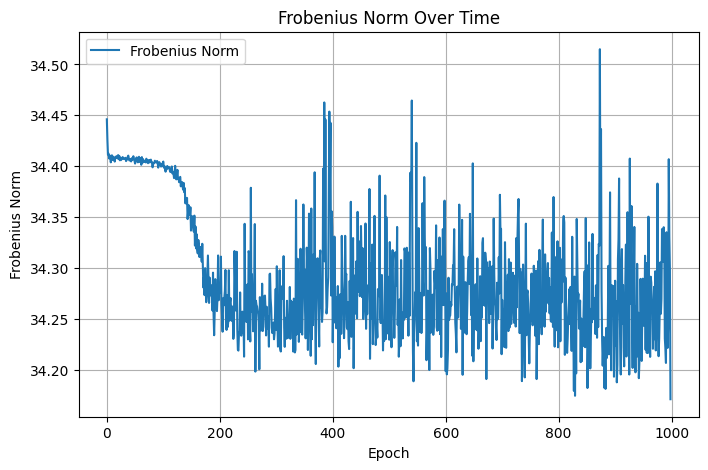

Run link: https://wandb.ai/wlp9800-new-york-university/rnn-test/runs/9hvetqgn


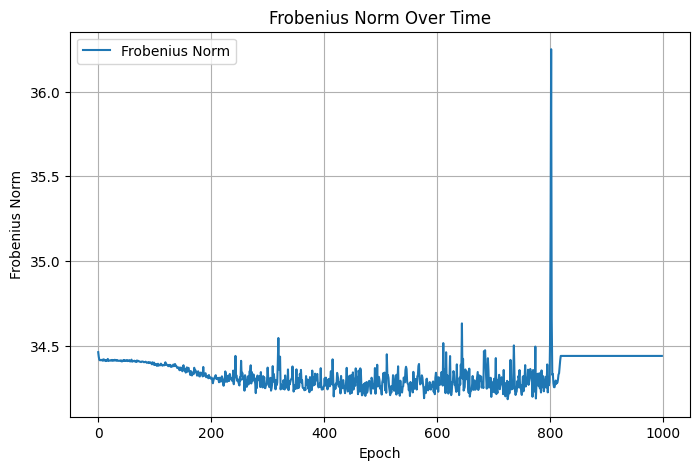

Explosion detected at epoch 801!
Frobenius norm: 35.16757290910168
Eigenvalues at epoch 801: [-4.61508131 -2.91806221 -1.97190893 -1.61598468 -1.23388743 -1.14925659
 -0.84785479  2.25364685 -0.40852648 -0.28867659 -0.13505745  1.992661
 -0.03762633  0.10100633  0.17024182  1.71920717  0.28038585  1.65560567
  0.32182017  0.37264514  1.59538043  1.58034277  0.39978528  0.42928088
  1.54651093  1.52632928  1.52632928  1.49934077  0.47204304  0.48020309
  0.48408079  0.51815301  0.53316528  1.46355045  1.44806874  1.42921436
  1.42104053  1.41418409  0.56272596  0.56860089  0.57678509  0.59140974
  0.60668457  0.60284388  1.39373541  1.38140225  0.62511897  0.63111025
  1.371611    0.63943088  1.36332417  0.65169752  0.65550089  0.6650877
  0.67785001  1.35257483  1.35257483  1.34105182  1.33631396  0.68756819
  1.31881547  1.31346154  1.31346154  1.30865753  0.70289755  0.70289755
  0.71244299  0.71854866  1.28948748  1.2848841   1.2848841   1.27744544
  1.27744544  0.72718096  1.260685

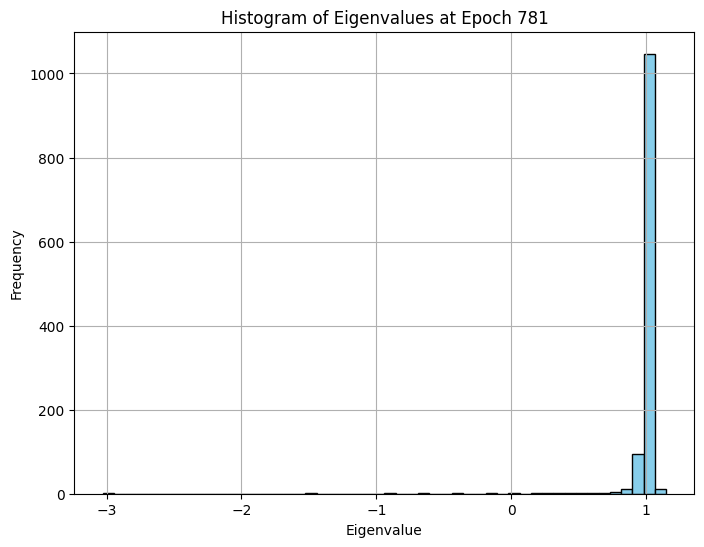

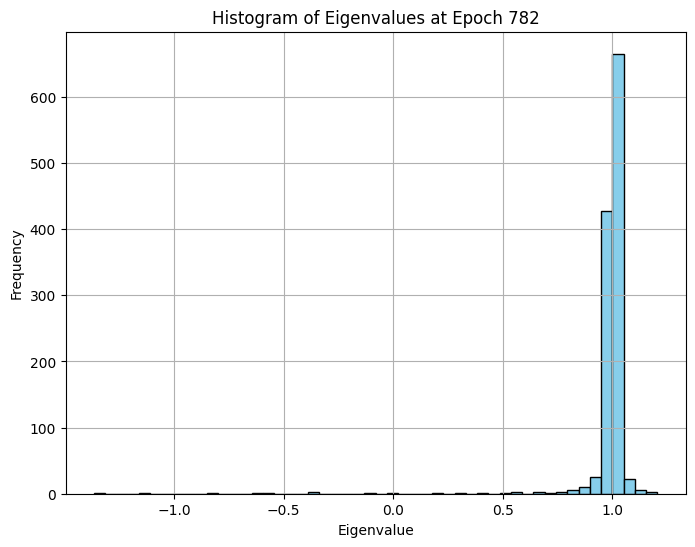

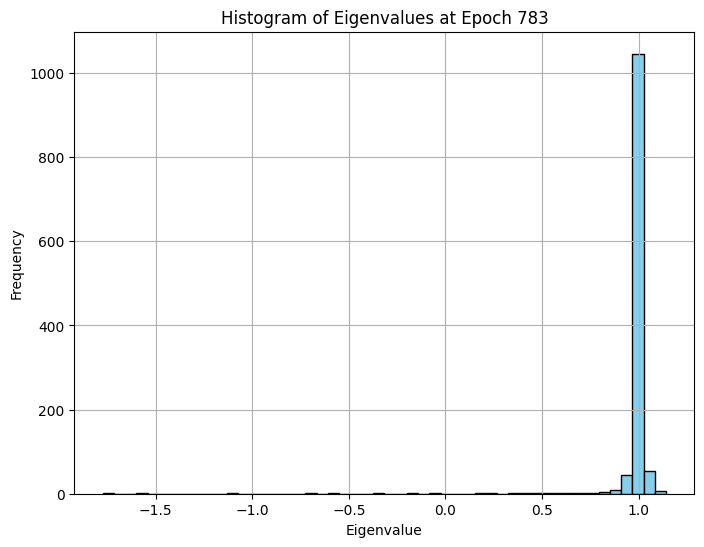

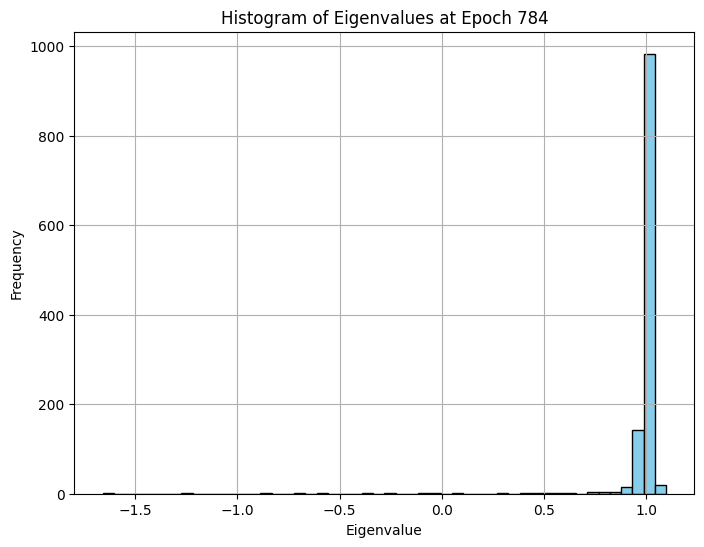

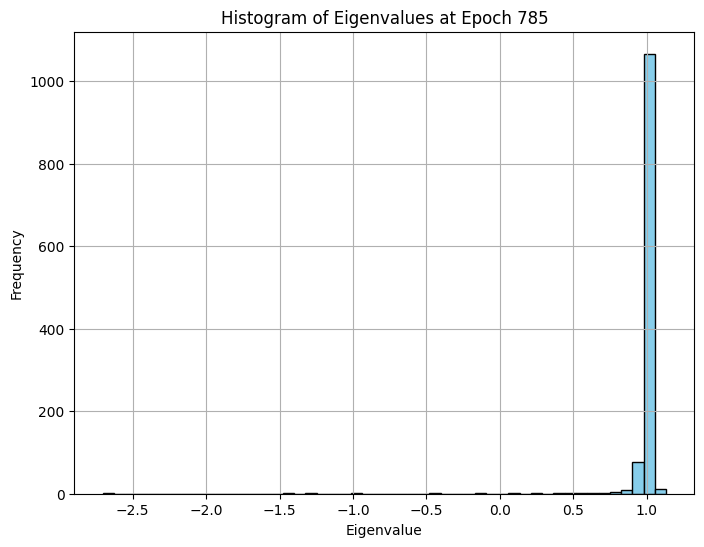

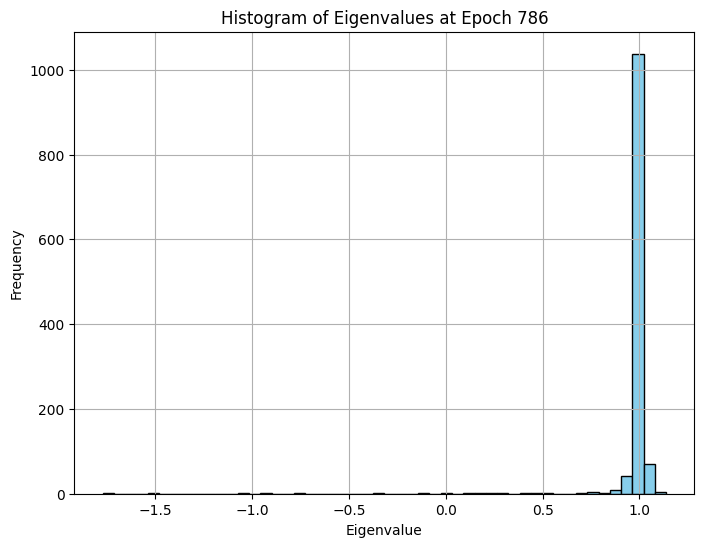

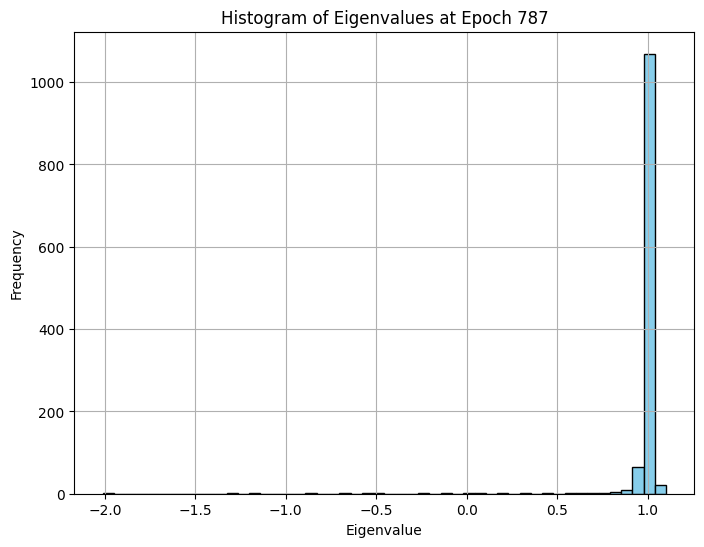

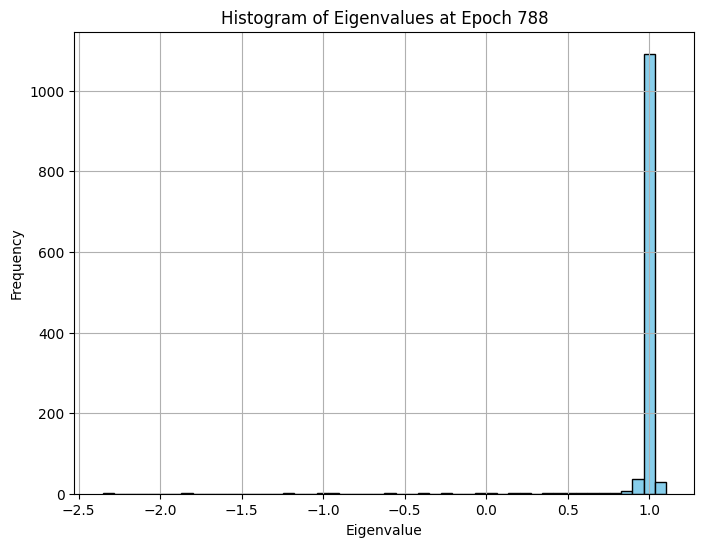

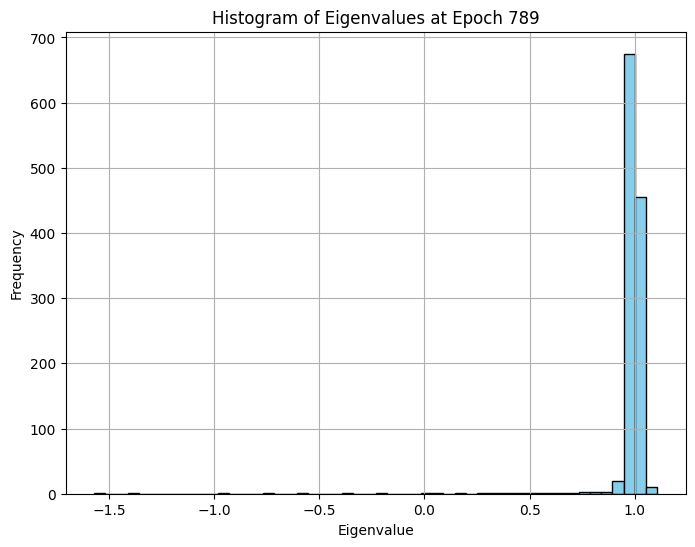

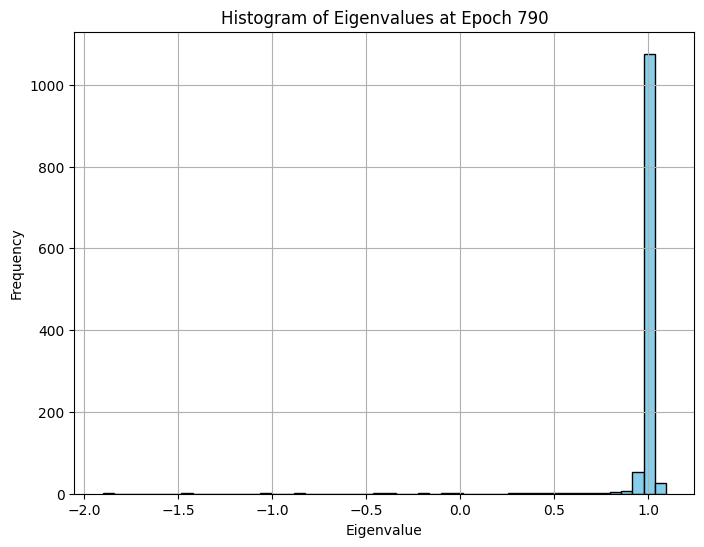

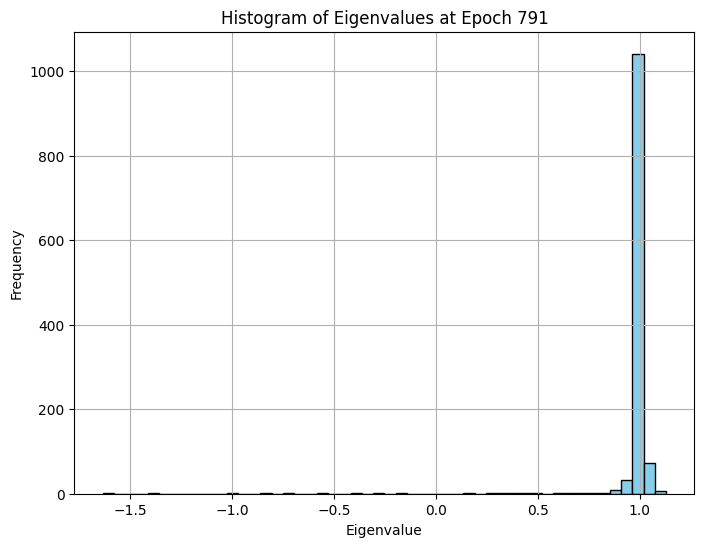

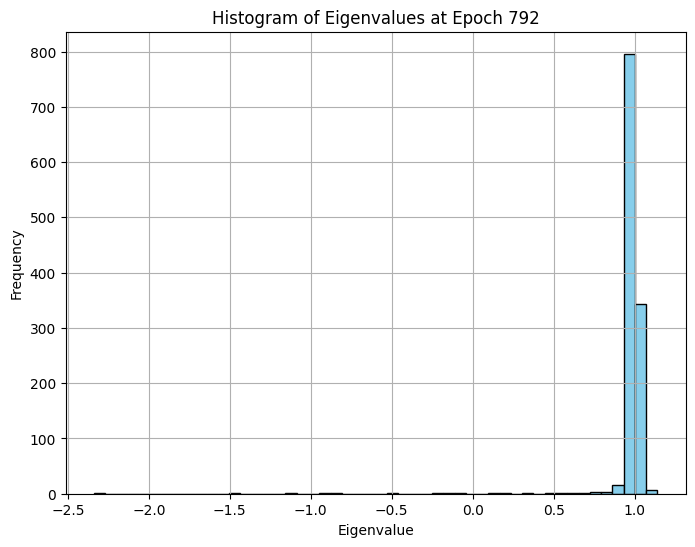

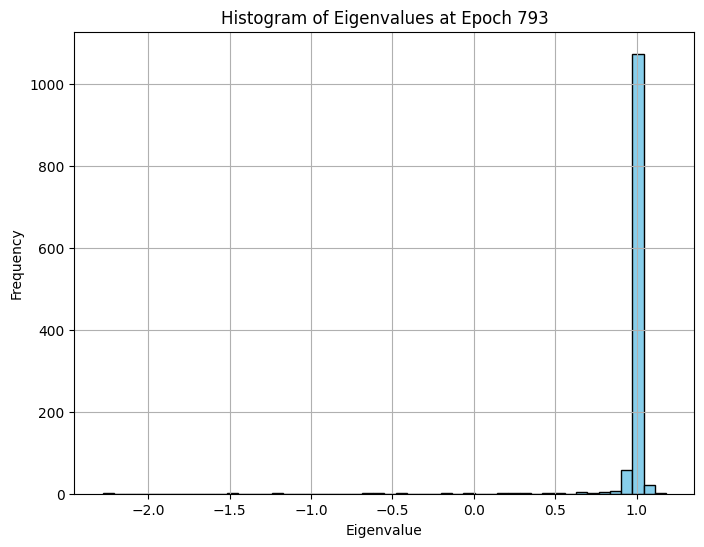

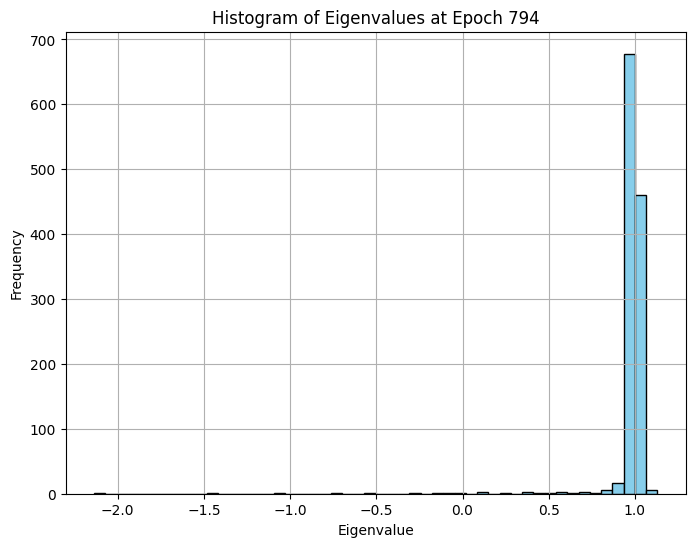

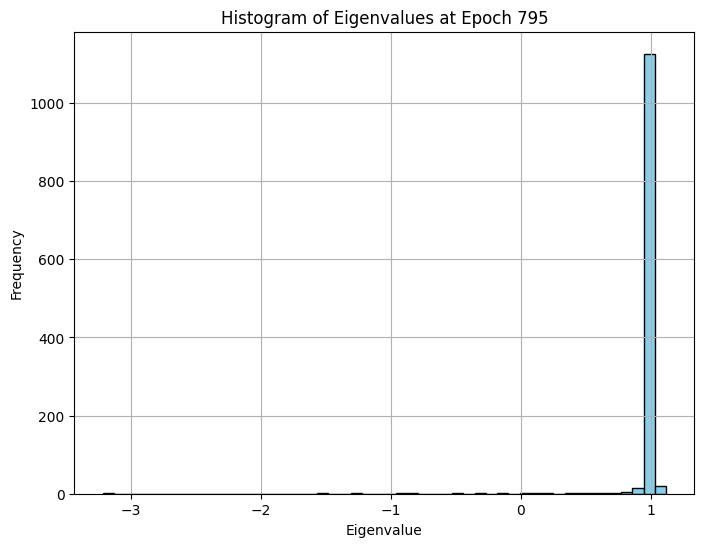

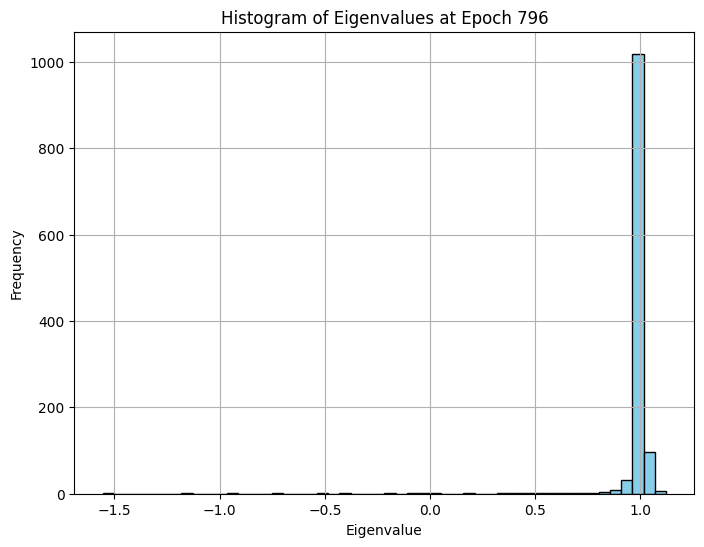

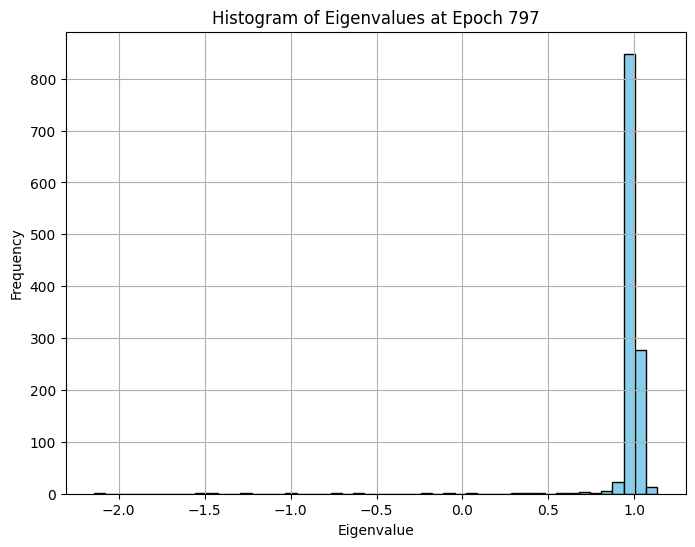

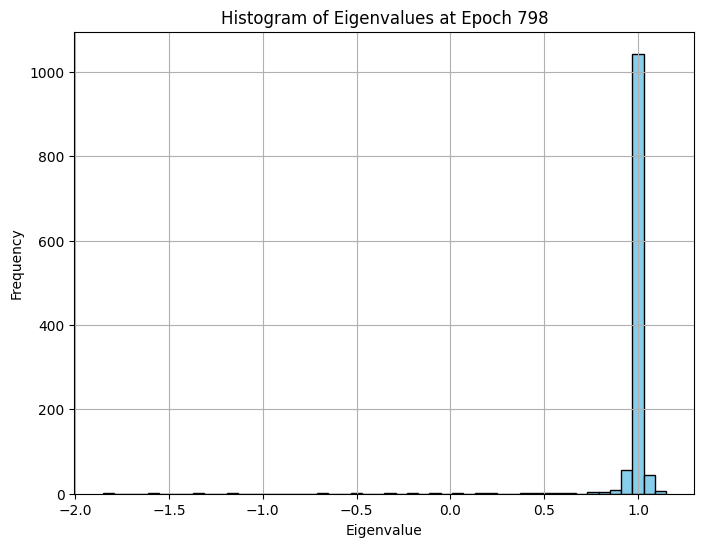

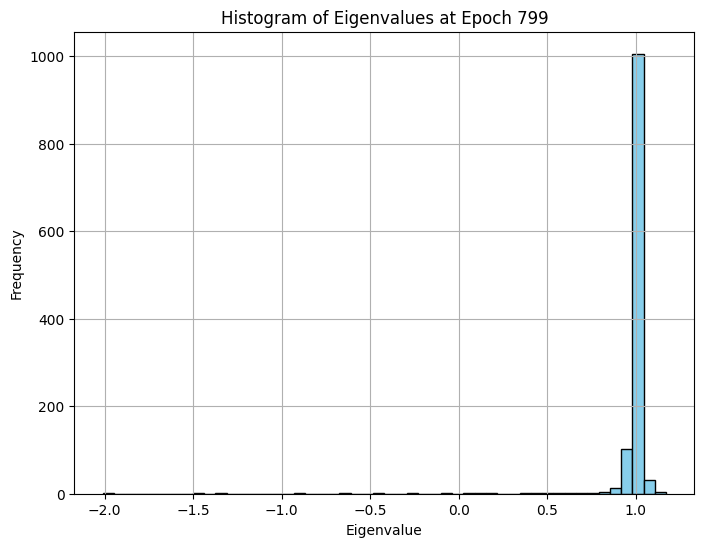

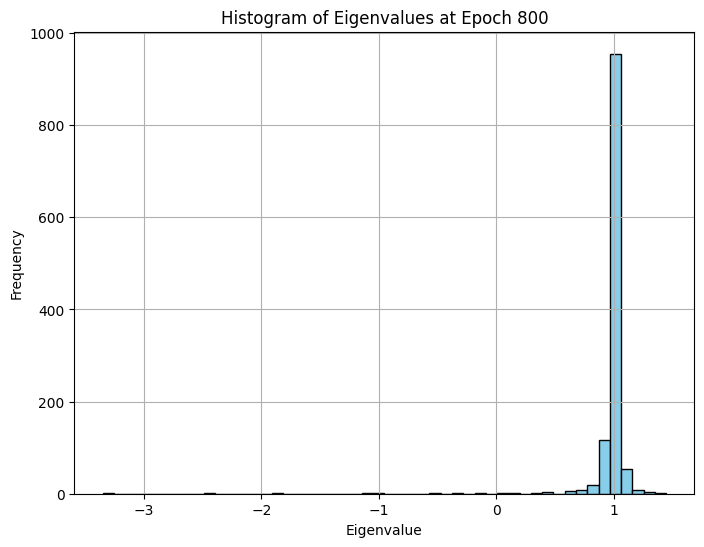

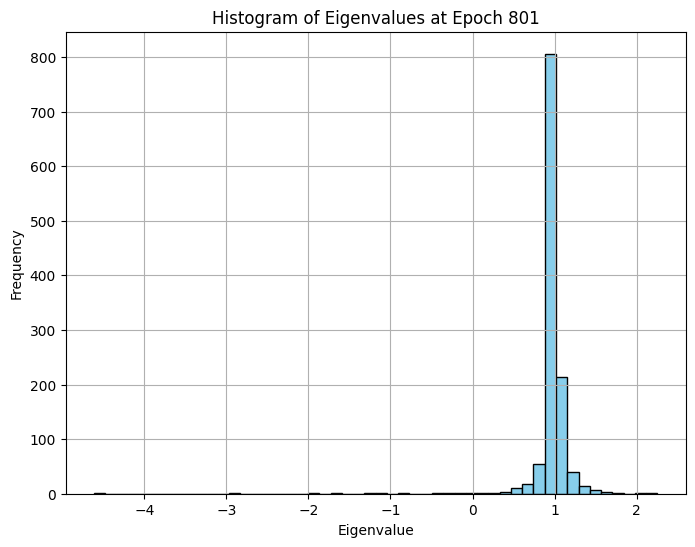

Run link: https://wandb.ai/wlp9800-new-york-university/rnn-test/runs/gtaztzr2


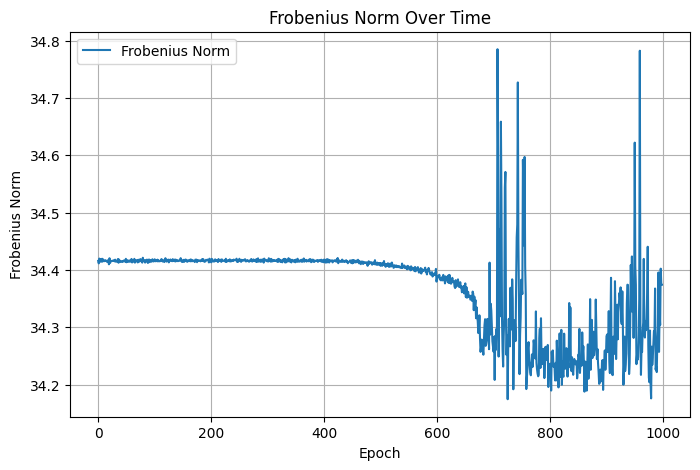

Run link: https://wandb.ai/wlp9800-new-york-university/rnn-test/runs/srizfldp


In [8]:
# for sweep_id, runs in data.items():
#     for run_id, run_info in runs.items():
#         eigenvalues_per_epoch = run_info["eigenvalues"]
#         filtered_eigenvalues, cumprod_vals = detect_explosion(eigenvalues_per_epoch)

#         frobenius_norms = compute_frobenius_norm(eigenvalues_per_epoch)
#         plot_frobenius_norm(frobenius_norms)
        
#         np.set_printoptions(threshold=np.inf)
#         detect_explosion_and_print_array(frobenius_norms, eigenvalues_per_epoch)
#         print(f"Run link: {run_info['url']}")



        # if filtered_eigenvalues.shape[0] > 0:
        #     print(f"Explosion detected in sweep {sweep_id}, run {run_info['name']} ({run_id})")
        #     print(f"Run link: {run_info['url']}")
        #     plot_eigenvalues(cumprod_vals, "Cumulative Eigenvalues Over Time")
        #     plot_eigenvalues(filtered_eigenvalues, "Filtered Eigenvalues Over Time")
        # else:
        #     print(f"No explosion detected in sweep {sweep_id}, run {run_info['name']} ({run_id})")
        #     print(f"Run link: {run_info['url']}")
        #     # plot_first_dimension(eigenvalues_per_epoch, "First Dimension Eigenvalues Over Time")
        #     plot_trajectory_with_greatest_log_cumsum(eigenvalues_per_epoch, "Eigenvalues Over Time (Log Space)")

